<a href="https://colab.research.google.com/github/bachvu98/Policy-NLP/blob/master/Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import listdir
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from lxml import etree, html

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
segments = pd.read_csv('/content/drive/My Drive/OPP-115/OPP-115/segment_processed.csv',index_col=0)
segments.head()

,Policy UID,segment_id,category_name,segments
0,20,0,Other,strong privacy policy strong br br strong effe...
1,20,1,Other,privacy policy apply site maintained company o...
2,20,2,Policy Change,visiting site accepting practice described pri...
3,20,3,First Party Collection/Use,strong information collected strong br br coll...
4,20,4,First Party Collection/Use,strong personally identifiable information str...


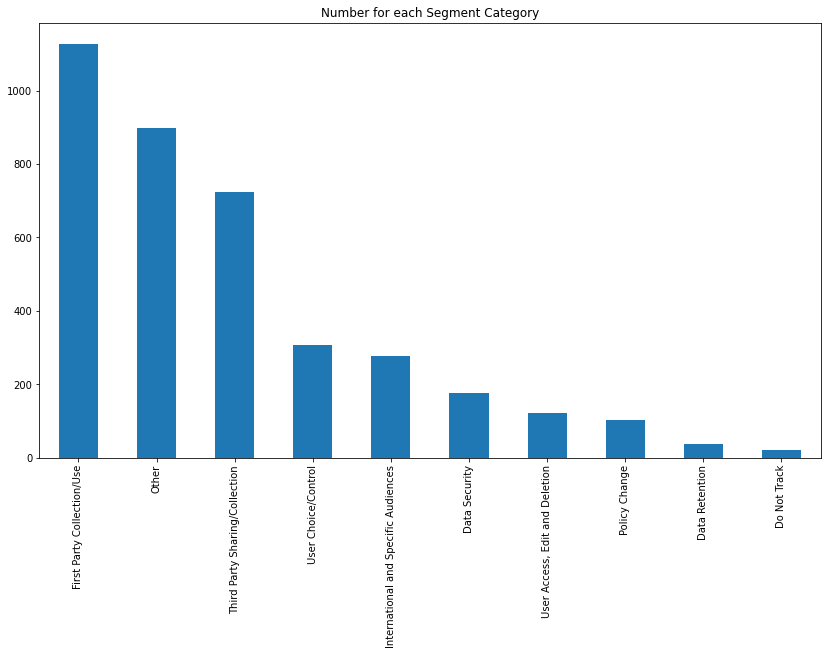

In [3]:
ax = segments['category_name'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Segment Category")

In [68]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(segments['segments'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(segments['segments']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df = pd.DataFrame(tfid_matrix, columns=feature_names)
df.head(10)

df['output'] = segments['category_name']
df

,aaa,aaassuch,aad,abandoned,abc,abide,ability,abita,abitacom,able,abovedescribed,abovedesignated,abroad,absolute,abuse,abused,abusiness,abusive,academic,acc,accelerate,accept,acceptable,acceptance,accepted,accepting,accepts,access,accessed,accessibility,accessible,accessing,accessupdate,accident,accidental,accidentally,accommodate,accompanied,accompanies,accompanying,...,wwwthecarconnectioncom,wwwthedmaorg,wwwtrustecomwatchdog,wwwuhedu,wwwusplaystationcom,wwwvikingscom,xbox,xcompanycom,xi,xii,xiii,xiv,xp,xrated,xyz,xyzs,yahoo,year,yes,yet,york,youd,youll,young,younger,yourcaliforniaprivacyrightscom,youre,yourpersonally,yourschooledu,youtube,youve,zacks,zackscom,zealand,zero,zip,zipscene,zipscenecomprivacy,zone,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054918,0.0,0.0,0.0,0.066492,0.0,0.033387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Policy Change
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,First Party Collection/Use
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,First Party Collection/Use
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.074102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
3789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
3790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [69]:
#Split data using 30%/70% split
segments_train, segments_test, targets_train, targets_test = train_test_split(df[feature_names], 
    df[output], test_size=0.3, random_state=10)

In [43]:
from imblearn.over_sampling import SMOTE

In [48]:
smote = SMOTE('minority')
segments_smote, targets_smote = smote.fit_sample(segments_train, targets_train)
smote_df = pd.concat([pd.DataFrame(segments_smote, columns=feature_names), pd.DataFrame(targets_smote, columns=['output'])], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [76]:
from sklearn.multiclass import OneVsRestClassifier

#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops a Naive Bayes classifier.
text_clf= Pipeline([('vectorizer',CountVectorizer(ngram_range=(1,3))),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                    ('clf', OneVsRestClassifier(svm.SVC()))
                    ])

In [97]:
alpha_list1 = np.linspace(0.005, 0.1, 20)
alpha_list1 = np.around(alpha_list1, decimals=4)
alpha_list1

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  ])

In [98]:
#paramater selection
start_time = time.time()

parameters = [{'clf__estimator__C': [0.001, 0.01, 0.1, 1, 10],
              'clf__estimator__degree': [2, 3, 4],
              'clf__estimator__kernel': ['rbf', 'poly', 'sigmoid'],
              'clf__estimator__gamma':  [0.001, 0.01, 0.1, 1, 10],
              }]

parameter_grid = [{"alpha":alpha_list1}]

classifier1 = MultinomialNB()

gs_clf = GridSearchCV(classifier1, parameter_grid, n_jobs=-1, cv=2, verbose=1)
gs_clf = gs_clf.fit(smote_df[features],smote_df[output])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')
print("Best parameter: ",gs_clf.best_params_)
print("Best score: ",gs_clf.best_score_) 

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done training in 4.938336610794067 seconds.
Best parameter:  {'alpha': 0.015}
Best score:  0.7657059939260529


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.7s finished


In [ ]:
results = pd.DataFrame()
# collect alpha list
results['alpha'] = gs_clf.cv_results_['param_clf__C'].data
# collect test scores
results['score'] = gs_clf.cv_results_['mean_test_score'].data

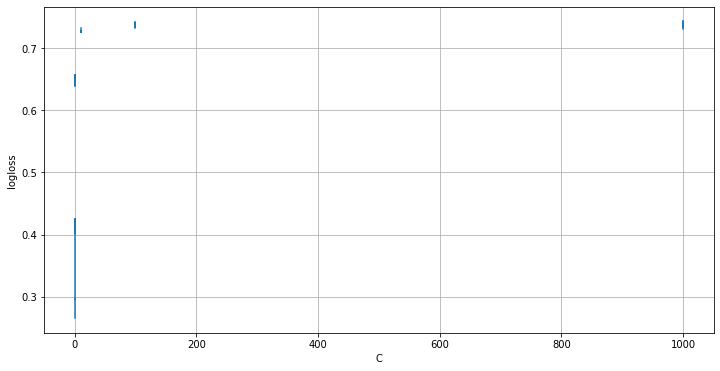

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('logloss')
plt.grid()

In [110]:
text_clf_final= Pipeline([('vectorizer',CountVectorizer(ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                    ('clf', svm.SVC(C = 10,
                         degree = 2,
                         gamma = 0.1,
                         kernel = 'rbf'))
                    ])

In [113]:
text_clf_final = svm.SVC(C = 10,
                         degree = 2,
                         gamma = 0.1,
                         kernel = 'rbf')

In [99]:
text_clf_final = MultinomialNB(alpha = 0.015)

In [117]:
#text_clf_final = gs_clf.best_estimator_
text_clf_final.fit(segments_train,targets_train)
#text_clf_final.fit(smote_df[features],smote_df[output])
preds = text_clf_final.predict(segments_test)
print('Accuracy =', np.mean(preds == targets_test))

Accuracy = 0.7451669595782073


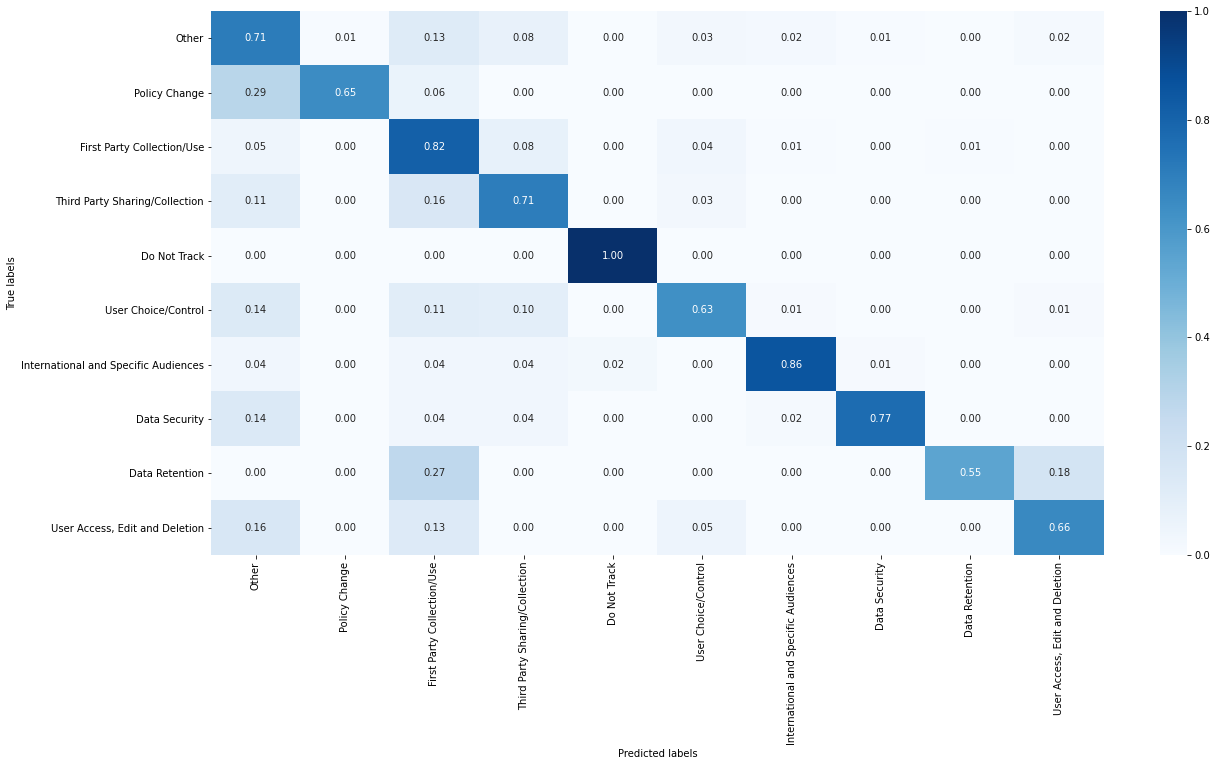

In [118]:
labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), preds.astype(str), labels )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax= plt.subplot()
plt.rcParams['figure.figsize'] = (20, 10)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [119]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),preds.astype(str)))

                                      precision    recall  f1-score   support

                      Data Retention       0.75      0.55      0.63        11
                       Data Security       0.93      0.77      0.84        56
                        Do Not Track       0.71      1.00      0.83         5
          First Party Collection/Use       0.75      0.82      0.78       342
International and Specific Audiences       0.88      0.86      0.87        84
                               Other       0.71      0.71      0.71       272
                       Policy Change       0.87      0.65      0.74        31
      Third Party Sharing/Collection       0.71      0.71      0.71       218
      User Access, Edit and Deletion       0.76      0.66      0.70        38
                 User Choice/Control       0.64      0.63      0.63        81

                            accuracy                           0.75      1138
                           macro avg       0.77      0.73     